In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import random
from numpy import savetxt
import re
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

seed = 22
np.random.seed(seed)

auth_manager = SpotifyClientCredentials(client_id='5e87783324eb47cba39f43f39e374c71',client_secret='68427108059946e9abfa226df5780371')
sp = spotipy.Spotify(auth_manager=auth_manager)

In [2]:
def flatten(l):
    return [item for sublist in l for item in sublist]

def encode_values(col):
    unique_items = np.unique(col)
    items_to_encoded = {x: i for i, x in enumerate(unique_items)}
    encoded_to_items = {i: x for i, x in enumerate(unique_items)}
    return (items_to_encoded, encoded_to_items)

playlist_df = pd.read_json('./datasets/challenge_set.json')
playlist_series = playlist_df['playlists']
playlist_data = []

# reduce the size of the dataset for ease of use.
for item in playlist_series[::20]:
    if len(item['tracks']) > 0 and 'name' in item and re.search("[a-zA-Z]+", item['name']) is not None:
        dataset = { 'name': item['name'].lower(), 'tracks': [] }
        for track in item['tracks']:
            dataset['tracks'].append(track['track_uri'].split(':')[2])
        playlist_data.append(dataset)

In [3]:
playlists = [playlist['name'].split(' ') for playlist in playlist_data]
playlists = pd.Series(np.unique(flatten(playlists)))
playlist_items_to_encoded, playlist_encoded_to_items = encode_values(playlists)
encoded_playlists = playlists.map(playlist_items_to_encoded)

tracks = [playlist['tracks'] for playlist in playlist_data]
tracks = pd.Series(np.unique(flatten(tracks)))
track_id_items_to_encoded, track_id_encoded_to_items = encode_values(tracks)
encoded_tracks = tracks.map(track_id_items_to_encoded)

In [4]:
playlist_histogram = {playlist_id: set() for playlist_id in encoded_playlists}

for playlist in playlist_data:
    for name in playlist['name'].lower().split(' '):
        for track in playlist['tracks']:
            playlist_histogram[playlist_items_to_encoded[name]].add(track_id_items_to_encoded[track])

x = np.empty((len(playlists) * len(tracks), 2), np.uintc)
y = np.zeros(len(playlists) * len(tracks), np.byte)

for playlist_id, histogram_track_ids in playlist_histogram.items():
    # iterate though histogram
    for track_id in histogram_track_ids:
        index = playlist_id * len(playlists) + track_id
        y[index] = 1

    # iterate through all tracks
    for track_id in encoded_tracks:
        index = playlist_id * len(playlists) + track_id
        x[index][0] = playlist_id
        x[index][1] = track_id

array_shuffle = np.arange(len(x))
np.random.shuffle(array_shuffle)

x = np.array(x)[array_shuffle]
y = np.array(y)[array_shuffle]
print(x.size)

train_indices = int(0.9 * len(x))
x_train = x[:train_indices]
y_train = y[:train_indices]
x_test = x[train_indices:]
y_test = y[train_indices:]

4626440


In [5]:
class TrackRecommender(keras.Model):
    def __init__(self, playlist_count, track_count, embedding_size, **kwargs):
        super().__init__(**kwargs)
        self.playlist_embedding = keras.layers.Embedding(
            playlist_count,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.playlist_bias = keras.layers.Embedding(playlist_count, 1)
        self.track_embedding = keras.layers.Embedding(
            track_count,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.track_bias = keras.layers.Embedding(track_count, 1)

    def call(self, inputs):
        playlist_vector = self.playlist_embedding(inputs[:, 0])
        playlist_bias = self.playlist_bias(inputs[:, 0])
        track_vector = self.track_embedding(inputs[:, 1])
        track_bias = self.track_bias(inputs[:, 1])
        
        dot = tf.tensordot(playlist_vector, track_vector, 2)
        x = dot + playlist_bias + track_bias
        return tf.nn.sigmoid(x)

model = TrackRecommender(len(playlists), len(tracks), 100)
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [6]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=128,
    epochs=5,
    verbose=2,
    validation_data=(x_test, y_test),
)

Epoch 1/5
16265/16265 - 86s - loss: 0.0235 - accuracy: 0.9930 - val_loss: 0.0206 - val_accuracy: 0.9926 - 86s/epoch - 5ms/step
Epoch 2/5
16265/16265 - 86s - loss: 0.0187 - accuracy: 0.9931 - val_loss: 0.0198 - val_accuracy: 0.9927 - 86s/epoch - 5ms/step
Epoch 3/5
16265/16265 - 86s - loss: 0.0187 - accuracy: 0.9930 - val_loss: 0.0198 - val_accuracy: 0.9927 - 86s/epoch - 5ms/step
Epoch 4/5
16265/16265 - 86s - loss: 0.0187 - accuracy: 0.9930 - val_loss: 0.0200 - val_accuracy: 0.9927 - 86s/epoch - 5ms/step
Epoch 5/5
16265/16265 - 86s - loss: 0.0187 - accuracy: 0.9930 - val_loss: 0.0201 - val_accuracy: 0.9926 - 86s/epoch - 5ms/step


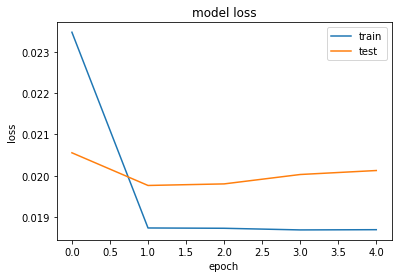

In [7]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"])
plt.show()

In [33]:
# choose a playlist name here
playlist_name = 'old country'

def predict(word):
    playlist_id = playlist_items_to_encoded[word]

    input1 = [[item] for item in np.repeat(playlist_id, len(tracks))]
    input2 = [[item] for item in list(track_id_encoded_to_items.keys())]
    input_matrix = np.hstack((input1, input2))

    return np.array(model.predict(input_matrix).flatten())

print('Selected playlist name: ' + playlist_name)
playlist_name = playlist_name.lower()

print('Running recommendation:')
valid_words = [name for name in playlist_name.split(' ') if name in playlist_items_to_encoded]
prediction_list = [predict(word) for word in valid_words]
prediction = np.prod(np.vstack(prediction_list), axis=0)

recommended_indices = np.argsort(prediction)[::-1][:5]
recommended_tracks = [sp.track(track_id_encoded_to_items[index]) for index in recommended_indices]

prediction.sort()
prediction_values = prediction[::-1][:5]
print('Recommended Songs:')
for index, track in enumerate(recommended_tracks):
    #print(track)
    print('Track: ' + track['name'] + ' ' + track['id'])
    print('Recommendation Strength: ' + str(prediction_values[index]))
    artists = sp.artists([artist['id'] for artist in track['artists']])['artists']
    artist_names = [artist['name'] for artist in artists]
    artist_genres = np.unique(flatten([artist['genres'] for artist in artists]))
    print('Artists: ' + str.join(', ', artist_names))
    print('Genres: ' + str.join(', ', artist_genres))
    print('----')


Selected playlist name: old country
Running recommendation:
252/252 [==============================] - 0s 986us/step
Recommended Songs:
Track: Avian 07MbhdbZiKm0HTeE8NbR6S
Recommendation Strength: 0.6115308
Artists: Mac Miller
Genres: hip hop, pittsburgh rap, pop rap, rap
----
Track: Go Your Own Way - 2004 Remaster 07GvNcU1WdyZJq3XxP0kZa
Recommendation Strength: 0.6109108
Artists: Fleetwood Mac
Genres: album rock, classic rock, rock, soft rock, yacht rock
----
Track: Never Let Me Down 06TqBu4Vi2DEu2F2wNTEnb
Recommendation Strength: 0.5799895
Artists: Kanye West, JAY-Z, J. Ivy
Genres: chicago rap, east coast hip hop, gangster rap, hip hop, pop rap, rap
----
Track: Irreplaceable 07lxDm1s8FVO4GF54Nooiz
Recommendation Strength: 0.5566841
Artists: Beyoncé
Genres: pop, r&b
----
Track: 143 06qEvINEo4vjkZUCN06SmT
Recommendation Strength: 0.54807407
Artists: Bobby Brackins, Ray J
Genres: cali rap, pop rap, slow game
----
